In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import re

In [0]:
data = pd.read_csv('req_ans_learn.tsv', sep='\t', names=['query', 'doc'])
data.head()

,query,doc
0,麒麟倶楽部,/wiki/Qilin
1,data integrity что это,/wiki/Data_integrity
2,a harmonious rejuvenation Add to your retreat ...,/wiki/Balmoral_Castle
3,Can Can,/wiki/Can-can
4,all the quiet,/wiki/All_Quiet_on_the_Western_Front


In [0]:
test_data = pd.read_csv('req_ans_test_no_url.tsv', names=['query'])
test_data.head()

,query
0,there are two rivers in the city: the Selenga
1,biriani spice
2,бернли команда
3,he 114
4,википедия про мегатрона из кино 3 википедия


In [0]:
data.shape

(491044, 2)

In [0]:
test_data.shape

(137986, 1)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491044 entries, 0 to 491043
Data columns (total 2 columns):
query    491042 non-null object
doc      491044 non-null object
dtypes: object(2)
memory usage: 7.5+ MB


In [0]:
original_doc = data.doc.unique()
original_doc.shape

(66060,)

In [0]:
def process_string(string):
    s = " ".join(re.sub('[^a-zA-Zа-яА-ЯёЁ0-9]+', ' ', string.lower()).split()).lower()
    return s if s != "" else None

In [0]:
def process_doc(string):
  doc = string.split('/')[-1]
  return process_string(doc)

In [0]:
original_processed_doc = {doc:process_doc(doc) for doc in original_doc}

In [0]:
processed_original_doc = {value:key for key, value in original_processed_doc.items() if value is not None}

In [0]:
len(original_processed_doc), len(processed_original_doc)

(66060, 66022)

In [0]:
query_str = data['query'].values
query_str.shape

(491044,)

In [0]:
data['query'] = [process_string(str(s)) for s in query_str]

In [0]:
data.doc = [process_doc(s) for s in data.doc.values]

In [0]:
data.head(10)

,query,doc
0,None,qilin
1,data integrity что это,data integrity
2,a harmonious rejuvenation add to your retreat ...,balmoral castle
3,can can,can can
4,all the quiet,all quiet on the western front
5,liliaceae tulipa lord beaconsfield parmesiano,liliaceae
6,hunan,hunan
7,vince vaughn,vince vaughn
8,iutube,youtube
9,the silence of the somme sound and realism in ...,battle of the somme


In [0]:
query_vocab_counter['вики']

3336

In [0]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486774 entries, 1 to 491043
Data columns (total 2 columns):
query    486774 non-null object
doc      486774 non-null object
dtypes: object(2)
memory usage: 11.1+ MB


In [0]:
data.head(10)

,query,doc
1,data integrity что это,data integrity
2,a harmonious rejuvenation add to your retreat ...,balmoral castle
3,can can,can can
4,all the quiet,all quiet on the western front
5,liliaceae tulipa lord beaconsfield parmesiano,liliaceae
6,hunan,hunan
7,vince vaughn,vince vaughn
8,iutube,youtube
9,the silence of the somme sound and realism in ...,battle of the somme
10,kayle minogue,kylie minogue


In [0]:
processed_doc = data.doc.unique()
processed_doc.shape

(65999,)

In [0]:
processed_original_doc[processed_doc[0]]

'/wiki/Data_integrity'

In [0]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(data, test_size=0.2)
train_data.shape, valid_data.shape

((389419, 2), (97355, 2))

In [0]:
from collections import Counter

In [0]:
query_vocab_counter = Counter()
for s in train_data['query'].values:
  query_vocab_counter.update(s.split())
len(query_vocab_counter)

207908

In [0]:
max(query_vocab_counter.values())

61601

In [0]:
query_vocab_counter.most_common(20)

[('the', 61601),
 ('of', 40094),
 ('википедия', 21851),
 ('and', 21563),
 ('in', 21005),
 ('a', 19005),
 ('to', 15549),
 ('is', 15244),
 ('wiki', 11326),
 ('for', 7003),
 ('s', 6253),
 ('on', 5316),
 ('that', 5192),
 ('as', 4912),
 ('with', 4875),
 ('are', 4873),
 ('это', 4744),
 ('it', 4694),
 ('wikipedia', 4394),
 ('by', 4261)]

In [0]:
query_vocab = {key for key, value in query_vocab_counter.items() if 10 < value < 4000}
len(query_vocab)

16732

In [0]:
idx_query_token = ['<PAD>', '<UNK>'] + list(query_vocab)
len(idx_query_token)

16734

In [0]:
query_to_idx = {t: i for i, t in enumerate(idx_query_token)}
query_to_idx['<UNK>']

1

In [0]:
doc_vocab = set()
for d in processed_doc:
  doc_vocab.update(set(d.split()))
len(doc_vocab)

45927

In [0]:
idx_doc_token = ['<PAD>'] + list(doc_vocab)
doc_to_idx = {d: i for i, d in enumerate(idx_doc_token)}
doc_to_idx['usa'], idx_doc_token[29873]

(689, 'eye')

In [0]:
def iterate_minibatches(data, batch_size, total_batch_num, shuffle=True, cycle=False):
    indices = np.arange(len(data))
    cnt = 0
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            queries = batch['query'].values
            correct_answers = batch['doc'].values
            wrong_answers = np.random.choice(processed_doc, size=correct_answers.shape)
            yield {
                'queries' : queries,
                'correct': correct_answers,
                'wrong': wrong_answers
            }
            cnt += 1
            if cnt == total_batch_num:
                break
        if cnt == total_batch_num:
            break
        if not cycle:
            break

In [0]:
dummy_batch = next(iterate_minibatches(train_data.sample(3), 3, 10))
print(dummy_batch)

{'queries': array(['a famous picture house in trafalgar square',
       'products to maintain the cleaning process the body of',
       'hentai wikipedia host en wikipedia org'], dtype=object), 'correct': array(['trafalgar square', 'hygiene', 'hentai'], dtype=object), 'wrong': array(['dave madden', 'robert adler', 'restless heart whitesnake album'],
      dtype=object)}


In [0]:
def text_to_idx(string, mapper, UNK_IDX=1):
  return torch.LongTensor([mapper[t] if t in mapper else UNK_IDX for t in string.split()])

In [0]:
text_to_idx(dummy_batch["queries"][0], query_to_idx)

tensor([    1, 10842, 11275, 13924,     1, 12506, 10347])

In [0]:
def array_to_tensors(array, mapper, max_len=20, UNK_IDX=1):
  tensors = [text_to_idx(s, mapper, UNK_IDX=UNK_IDX)[:max_len] for s in array]
  lens = [len(tensor) for tensor in tensors]
  return tensors, lens
array_to_tensors(dummy_batch['queries'], query_to_idx)

([tensor([    1, 10842, 11275, 13924,     1, 12506, 10347]),
  tensor([ 6480,     1, 10106,     1, 12685,   240,     1,  9611,     1]),
  tensor([ 6558,     1, 11124, 12029,     1, 10972])],
 [7, 9, 6])

In [0]:
def pad_batch(array, mapper, max_len=20, UNK_IDX=1):
  tensors, lens = array_to_tensors(array, mapper, max_len, UNK_IDX)
  padded_tensor = nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0)
  lens = torch.LongTensor(lens)
  lens, order = torch.sort(lens, descending=True)
  return padded_tensor[order], lens, order

In [0]:
pad_batch(dummy_batch['queries'], query_to_idx)

(tensor([[ 6480,     1, 10106,     1, 12685,   240,     1,  9611,     1],
         [    1, 10842, 11275, 13924,     1, 12506, 10347,     0,     0],
         [ 6558,     1, 11124, 12029,     1, 10972,     0,     0,     0]]),
 tensor([9, 7, 6]),
 tensor([1, 0, 2]))

In [0]:
paded, lens, order = pad_batch(dummy_batch['queries'], query_to_idx)
paded

tensor([[ 6480,     1, 10106,     1, 12685,   240,     1,  9611,     1],
        [    1, 10842, 11275, 13924,     1, 12506, 10347,     0,     0],
        [ 6558,     1, 11124, 12029,     1, 10972,     0,     0,     0]])

In [0]:
emb = nn.Embedding(num_embeddings=16576, embedding_dim=4, padding_idx=0)

In [0]:
emb(paded).shape

torch.Size([3, 9, 4])

In [0]:
def reverse_order(order):
  rev_order = torch.zeros_like(order)
  for old, new in enumerate(order):
    rev_order[new] = old
  return rev_order

In [0]:
reverse_order(order)

tensor([1, 0, 2])

In [0]:
paded[reverse_order(order)]

tensor([[    1, 10842, 11275, 13924,     1, 12506, 10347,     0,     0],
        [ 6480,     1, 10106,     1, 12685,   240,     1,  9611,     1],
        [ 6558,     1, 11124, 12029,     1, 10972,     0,     0,     0]])

In [0]:
class SentenceEmbedder(nn.Module):
  def __init__(self, emb_num, emb_dim, hid_dim, lstm_num, lstm_dropout, dense_dim, dense_dropout):
    super(SentenceEmbedder, self).__init__()
    self.emb = nn.Embedding(num_embeddings=emb_num, embedding_dim=emb_dim, padding_idx=0)
    self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=lstm_num, batch_first=True,
                       bidirectional=True, dropout=lstm_dropout, )
    self.drop = nn.Dropout(dense_dropout)
    self.dense = nn.Linear(2 * hid_dim, dense_dim)
    nn.init.xavier_uniform_(self.dense.weight)
    
  def forward(self, input, lens):
    embedded_inp = self.emb(input)
    packed = nn.utils.rnn.pack_padded_sequence(embedded_inp, lens, batch_first=True)
    lstm_out, (h, c) = self.lstm(packed)
    unpack, new_lens = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, padding_value=0)
    average = torch.mean(unpack, dim=1)
    return self.dense(self.drop(average))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


In [0]:
query_embedder = SentenceEmbedder(emb_num=len(idx_query_token), emb_dim=512, hid_dim=1024, lstm_num=2, lstm_dropout=0.1,
                             dense_dim=1024, dense_dropout=0.1)

In [0]:
paded, lens, q_order = pad_batch(dummy_batch['queries'], query_to_idx)
q_emb = query_embedder(paded, lens)

In [0]:
doc_embedder = SentenceEmbedder(emb_num=len(idx_doc_token), emb_dim=512, hid_dim=1024, lstm_num=2, lstm_dropout=0.1,
                             dense_dim=1024, dense_dropout=0.1)

In [0]:
paded, lens, c_order = pad_batch(dummy_batch['correct'], doc_to_idx)
c_emb = doc_embedder(paded, lens)

In [0]:
paded, lens, w_order = pad_batch(dummy_batch['wrong'], doc_to_idx)
w_emb = doc_embedder(paded, lens)

In [0]:
q_emb.shape, c_emb.shape, w_emb.shape

(torch.Size([3, 1024]), torch.Size([3, 1024]), torch.Size([3, 1024]))

In [0]:
torch.max(torch.zeros(3), 1 - F.cosine_similarity(q_emb, c_emb) + F.cosine_similarity(q_emb, w_emb))

tensor([0.9563, 1.0139, 1.0444], grad_fn=<MaxBackward2>)

In [0]:
def compute_loss(query, pos, neg):
  pos_score = F.cosine_similarity(query, pos)
  neg_score = F.cosine_similarity(query, neg)
  loss = torch.max(torch.zeros_like(pos_score), 1 - pos_score + neg_score)
  return torch.mean(loss)

In [0]:
compute_loss(q_emb[reverse_order(q_order)], c_emb[reverse_order(c_order)], w_emb[reverse_order(w_order)])

tensor(1.0116, grad_fn=<MeanBackward1>)

In [0]:
with torch.cuda.device(0):
  query_embedder_gpu = query_embedder.cuda()
  doc_embedder_gpu = doc_embedder.cuda()
optim = torch.optim.Adam([{'params': query_embedder_gpu.parameters()}, 
                          {'params': doc_embedder_gpu.parameters()}], lr=0.001)

In [0]:
from tqdm import tqdm
from IPython.display import clear_output
import scipy.spatial.distance as ssd
from sklearn.metrics import accuracy_score

In [0]:
train_loss = []
val_acc = []
dev_batches = iterate_minibatches(valid_data, batch_size=1024, total_batch_num=1000, cycle=True, shuffle=True)

In [0]:
def calc_dev_results(dev_batch):
  with torch.no_grad():
      queries, q_lens, query_order = pad_batch(dev_batch['queries'], query_to_idx, max_len=20)
      correct, c_lens, corr_order = pad_batch(dev_batch['correct'], doc_to_idx, max_len=20)
      with torch.cuda.device(0):
        q_embed = query_embedder_gpu(queries.cuda(), q_lens.cuda())
        c_embed = doc_embedder_gpu(correct.cuda(), c_lens.cuda())
        true_query_order = reverse_order(query_order)
        true_corr_order = reverse_order(corr_order)
      q_embed = q_embed[true_query_order]
      c_embed = c_embed[true_corr_order]
  return q_embed.cpu().numpy(), c_embed.cpu().numpy()

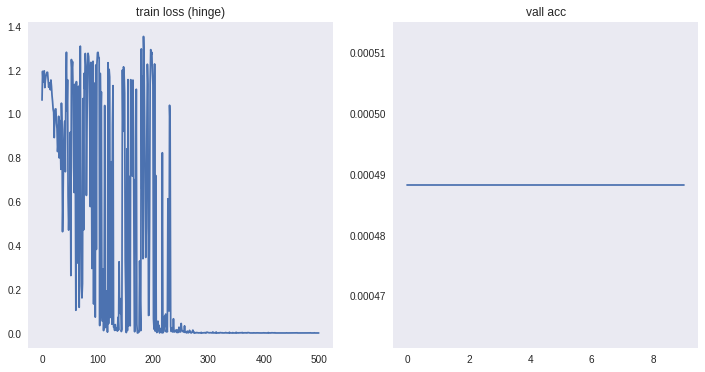


500it [18:41,  3.16s/it]


In [0]:
for batch in tqdm(iterate_minibatches(train_data, batch_size=1024, total_batch_num=500, cycle=True, shuffle=True)):
  query_embedder_gpu.train()
  doc_embedder_gpu.train()
  
  query_cpu, corr_cpu = calc_dev_results(batch)
  dist = ssd.cdist(query_cpu, corr_cpu, metric='cosine')
  dist += np.eye(len(query_cpu))
  hard_negs = np.argmin(dist, axis=1)
  
  queries, q_lens, query_order = pad_batch(batch['queries'], query_to_idx, max_len=20)
  correct, c_lens, corr_order = pad_batch(batch['correct'], doc_to_idx, max_len=20)

  true_corr_order = reverse_order(corr_order)
  true_correct = correct[true_corr_order]
  wrong = true_correct[hard_negs]
  w_lens = c_lens[true_corr_order][hard_negs]
  w_lens, wrong_order = torch.sort(w_lens, descending=True)
  wrong = wrong[wrong_order]
  
  with torch.cuda.device(0):
    q_embed = query_embedder_gpu(queries.cuda(), q_lens.cuda())
    c_embed = doc_embedder_gpu(correct.cuda(), c_lens.cuda())
    w_embed = doc_embedder_gpu(wrong.cuda(), w_lens.cuda())
    true_query_order = reverse_order(query_order)
    true_corr_order = reverse_order(corr_order)
    true_wrong_order = reverse_order(wrong_order)
  loss = compute_loss(q_embed[true_query_order], c_embed[true_corr_order], w_embed[true_wrong_order])
  loss.backward()
  optim.step()
  optim.zero_grad()
  
  train_loss.append(float(loss.detach().cpu().data))
  if len(train_loss) % 50 == 0:
    query_embedder_gpu.eval()
    doc_embedder_gpu.eval()
    
    dev_batch = next(dev_batches)
    q_embed_1, c_embed_1 = calc_dev_results(dev_batch)
    dev_batch = next(dev_batches)
    q_embed_2, c_embed_2 = calc_dev_results(dev_batch)
    q_embed = np.vstack((q_embed_1, q_embed_2))
    c_embed = np.vstack((c_embed_1, c_embed_2))
    dist = ssd.cdist(q_embed, c_embed, metric='cosine')
    nns = np.argmin(dist, axis=1)
    acc = accuracy_score(np.arange(len(q_embed)), nns)
    val_acc.append(acc)
      
  if len(train_loss) % 50 == 0:
    clear_output(True)
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
    plt.plot(train_loss)
    plt.subplot(1, 2, 2), plt.title('vall acc'), plt.grid()
    plt.plot(val_acc)
    plt.show()

In [0]:
array_to_tensors(processed_doc[:10], doc_to_idx, max_len=20)

([tensor([44172, 22687]),
  tensor([38750, 38124]),
  tensor([21322, 21322]),
  tensor([43955, 29728, 25548, 37503, 27806, 24262]),
  tensor([24698]),
  tensor([41515]),
  tensor([31066,  7752]),
  tensor([7707]),
  tensor([ 2831,  1841, 37503, 10635]),
  tensor([41141, 32657])],
 [2, 2, 2, 6, 1, 1, 2, 1, 4, 2])

In [0]:
pad_batch(processed_doc[:10], doc_to_idx, max_len=20)[0][reverse_order(pad_batch(processed_doc[:10], doc_to_idx, max_len=20)[2])]

tensor([[44172, 22687,     0,     0,     0,     0],
        [38750, 38124,     0,     0,     0,     0],
        [21322, 21322,     0,     0,     0,     0],
        [43955, 29728, 25548, 37503, 27806, 24262],
        [24698,     0,     0,     0,     0,     0],
        [41515,     0,     0,     0,     0,     0],
        [31066,  7752,     0,     0,     0,     0],
        [ 7707,     0,     0,     0,     0,     0],
        [ 2831,  1841, 37503, 10635,     0,     0],
        [41141, 32657,     0,     0,     0,     0]])

In [0]:
!pip install nmslib

In [0]:
import nmslib

In [0]:
index = nmslib.init(method='hnsw', space='cosinesimil')

In [0]:
inxs = np.arange(len(processed_doc))
doc_embedder_gpu.eval()
for bch_start in tqdm(range(0, len(processed_doc), 256)):
  bch_idx = inxs[bch_start:bch_start + 256]
  docs, lens, order = pad_batch(processed_doc[bch_idx], doc_to_idx, max_len=20)
  with torch.no_grad():
    with torch.cuda.device(0):
      docs_embed = doc_embedder_gpu(docs.cuda(), lens.cuda())
      true_order = reverse_order(order)
    index.addDataPointBatch(docs_embed[true_order].cpu().numpy(), bch_idx)


100%|██████████| 258/258 [00:12<00:00, 21.66it/s]


In [0]:
%%time
index.createIndex({'efConstruction': 1500, 'M':100, 'indexThreadQty': 16, 'post': 0}, print_progress=True)

CPU times: user 15min 15s, sys: 1.25 s, total: 15min 17s
Wall time: 7min 47s


In [0]:
%%time
index.setQueryTimeParams({'efSearch': 1500})

CPU times: user 71 µs, sys: 17 µs, total: 88 µs
Wall time: 94.2 µs


In [0]:
test_data['query'] = [process_string(str(s)) for s in test_data['query'].values]

In [0]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137986 entries, 0 to 137985
Data columns (total 2 columns):
query    137986 non-null object
doc      137986 non-null object
dtypes: object(2)
memory usage: 2.1+ MB


In [0]:
test_data.fillna('youtube', inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137986 entries, 0 to 137985
Data columns (total 2 columns):
query    137986 non-null object
doc      137986 non-null object
dtypes: object(2)
memory usage: 2.1+ MB


In [0]:
test_data.head()

,query,doc
0,there are two rivers in the city the selenga,/wiki/Sampling_(statistics)
1,biriani spice,/wiki/Isaac_Asimov
2,бернли команда,/wiki/Your_Name
3,he 114,/wiki/Middle_Way
4,википедия про мегатрона из кино 3 википедия,/wiki/Prince_of_Wales


In [0]:
test_data['doc'] = ['/wiki/Main'] * len(test_data)
test_data.head()

,query,doc
0,there are two rivers in the city the selenga,/wiki/Main
1,biriani spice,/wiki/Main
2,бернли команда,/wiki/Main
3,he 114,/wiki/Main
4,википедия про мегатрона из кино 3 википедия,/wiki/Main


In [0]:
index.knnQueryBatch([[0.1] * 1024, [0.2] * 1024], k=1, num_threads=4)

[(array([18231], dtype=int32), array([0.9215398], dtype=float32)),
 (array([18231], dtype=int32), array([0.9215398], dtype=float32))]

In [0]:
from tqdm import tqdm

In [0]:
inxs = np.arange(len(test_data))
query_embedder_gpu.eval()
for bch_start in tqdm(range(0, len(test_data), 512)):
  bch_idx = inxs[bch_start:bch_start + 512]
  batch = test_data.iloc[bch_idx]
  queries, lens, order = pad_batch(batch['query'].values, query_to_idx, max_len=20)
  with torch.no_grad():
    with torch.cuda.device(0):
      query_embed = query_embedder_gpu(queries.cuda(), lens.cuda())
      true_order = reverse_order(order)
    res = index.knnQueryBatch(query_embed[true_order].cpu().numpy(), k=1, num_threads=16)
  doc_res = [processed_doc[r[0][0]] for r in res]
  true_doc_name = [processed_original_doc[doc] for doc in doc_res]
  test_data.loc[bch_idx, 'doc'] = true_doc_name


100%|██████████| 270/270 [07:59<00:00,  1.65s/it]


In [0]:
test_data.head(10)

,query,doc
0,there are two rivers in the city the selenga,/wiki/Diagram
1,biriani spice,/wiki/Diagram
2,бернли команда,/wiki/Diagram
3,he 114,/wiki/Diagram
4,википедия про мегатрона из кино 3 википедия,/wiki/Diagram
5,новый орлеан рок группы начала 00s,/wiki/Diagram
6,the bella twins,/wiki/Diagram
7,d c in english,/wiki/Diagram
8,grade4 аналоги,/wiki/Diagram
9,трэвис,/wiki/Diagram


In [0]:
sub = pd.read_csv('sample.csv')
sub.head()

,Id,Category
0,1,/wiki/
1,2,/wiki/
2,3,/wiki/
3,4,/wiki/
4,5,/wiki/


In [0]:

sub.Category = test_data.doc
sub.head()

,Id,Category
0,1,/wiki/Diagram
1,2,/wiki/Diagram
2,3,/wiki/Diagram
3,4,/wiki/Diagram
4,5,/wiki/Diagram


In [0]:
sub.to_csv('subm.csv', index=False)